# Serializing acsets

Catlab supports the serialization of attributed C-sets (acsets) into JSON with their schemas.
This functionality should allow you to interoperate with database representations
in other languages by serializing both the data and the type into a network interoperability layer.

In [1]:
import JSON, JSONSchema

using Catlab, Catlab.Theories, Catlab.Graphs, Catlab.CategoricalAlgebra
using Catlab.Graphics

You can interact with the schema representation using JSON Schema with the
`write_json_acset_schema` and `read_json_acset_schema` functions.

In [2]:
function roundtrip_json_acset_schema(pres::Presentation)
  mktempdir() do dir
    path = joinpath(dir, "schema.json")
    write_json_acset_schema(pres, path)
    read_json_acset_schema(path)
  end
end

roundtrip_json_acset_schema (generic function with 1 method)

## The JSONSchema for Schemas
The following code shows how to view the schema for storing schemas.
You can see that this data is encoded in the standardized JSONSchema format,
which is a generic way of representing data structures that are serialized to JSON.
Notice that there are properties for Homs and Obs.
The Homs have fields like name, dom, and codom. The Obs just have a name.
AttrTypes are like Obs, but they store the name of the type that the attribute can have.
In Julia, the Schemas are parametric in the AttrTypes so that uses can set those types at instance creation time.
Attrs are the names of columns that point into the AttrTypes.

In [3]:
json_schema = JSONSchema.Schema(acset_schema_json_schema())
JSON.print(json_schema, 2)

{
  "data": {
    "id": "https://github.com/AlgebraicJulia/Catlab.jl/tree/master/test/categorical_algebra/acset.schema.json",
    "$schema": "https://json-schema.org/draft/2020-12/schema",
    "title": "ACSet",
    "type": "object",
    "properties": {
      "version": {
        "type": "object",
        "properties": {
          "ACSetSchema": {
            "type": "string",
            "pattern": "^[0-9][0-9.]*",
            "additionalProperties": false
          },
          "Catlab": {
            "type": "string",
            "pattern": "^[0-9][0-9.]*",
            "additionalProperties": false
          }
        },
        "required": [
          "ACSetSchema",
          "Catlab"
        ]
      },
      "Ob": {
        "type": "array",
        "items": {
          "type": "object",
          "properties": {
            "name": {
              "type": "string"
            }
          },
          "required": [
            "name"
          ]
        }
      },
      "AttrType": 

## Example 1: Discrete Dynamical Systems

Here is an example of an ACSet schema for Discrete Dynamical Systems.
A DDS is just a set `X` whose elements we call states, and a function `next`, which take the current state and gives you the next state.
Such systems are used to model processes that occur autonomously and are the simplest possible dynamical system.

In [4]:
@present SchDDS(FreeSchema) begin
  X::Ob
  next::Hom(X,X)
end

JSON.print(generate_json_acset_schema(SchDDS), 2)

{
  "version": {
    "ACSetSchema": "0.0.1",
    "Catlab": "0.0.0"
  },
  "Ob": [
    {
      "name": "X"
    }
  ],
  "Hom": [
    {
      "name": "next",
      "codom": "X",
      "dom": "X"
    }
  ],
  "AttrType": [],
  "Attr": []
}


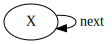

In [5]:
to_graphviz(SchDDS)

LabeledDDS are a variation on DDS where the states can have symbolic names. In Catlab, every element of an object has to be identified by its integer row number.
This comes out of a tradition in database design where every table has a natural number primary key. In mathematics, we often want to think of the state space not as a set of integers, but as an arbitrary set. In Catlab, we call that set the Labels and use a `label` attribute to implement the mapping of state numbers to state labels. This way the underlying database implementation can still be designed aroung natural number primary keys, but the user can use symbolic labels. Note also that this shows the schema inheritance. We state that a `SchLabeledDDS` inherits from `SchDDS` by adding a `label` attribute of type `Label`.

In [6]:
@present SchLabeledDDS <: SchDDS begin
  Label::AttrType
  label::Attr(X, Label)
end

JSON.print(generate_json_acset_schema(SchLabeledDDS), 2)

{
  "version": {
    "ACSetSchema": "0.0.1",
    "Catlab": "0.0.0"
  },
  "Ob": [
    {
      "name": "X"
    }
  ],
  "Hom": [
    {
      "name": "next",
      "codom": "X",
      "dom": "X"
    }
  ],
  "AttrType": [
    {
      "name": "Label"
    }
  ],
  "Attr": [
    {
      "name": "label",
      "codom": "Label",
      "dom": "X"
    }
  ]
}


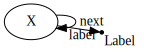

In [7]:
to_graphviz(SchLabeledDDS)

## Example 2: Labeled DDS

With the LabeledDDS, we will create an instance by specifying data that fits the schema.
Then we will create the JSON output to show how it is encoded.
The JSON encoded schema above tells you how to read the JSON encoded data below.
You can see that the `LabeledDDS` will have a set for `X` with a `Hom` for `next` and an attribute for `label`.
Thus we can expect to see the JSON encoding of a single table database below:
    1. The first level of JSON is keyed by the table names
    2. Each Table is an array of rows
    3. Each row is an object keyed by fields.
This is the simplest way to put a relational database in a JSON document. It is a little redundant, because the field names are repeated for each row. But that makes it easy to emit and easy to parse. If this becomes a problem, we can upgrade to a more efficient representation by writing more sophisticated parsers. Something like https://github.com/JuliaIO/MsgPack.jl would be appropriate.

In [8]:
@acset_type LabeledDDS(SchLabeledDDS, index=[:next, :label])

ldds = LabeledDDS{Int}()
add_parts!(ldds, :X, 4, next=[2,3,4,1], label=[100, 101, 102, 103])
JSON.print(generate_json_acset(ldds),2)

{
  "X": [
    {
      "next": 2,
      "label": 100
    },
    {
      "next": 3,
      "label": 101
    },
    {
      "next": 4,
      "label": 102
    },
    {
      "next": 1,
      "label": 103
    }
  ]
}


## Example 3: Graphs

Relational databases are great, because they are capable of representing almost anything that can be stored on a computer. We move up to graphs, which is a nice data structure you have probably seen before. Notably, graphs have two tables, one for edges and one for vertices. These are the category theorist's graph, which means that they support multiple parallel edges and self-loops.

In [9]:
JSON.print(generate_json_acset_schema(SchGraph), 2)

{
  "version": {
    "ACSetSchema": "0.0.1",
    "Catlab": "0.0.0"
  },
  "Ob": [
    {
      "name": "V"
    },
    {
      "name": "E"
    }
  ],
  "Hom": [
    {
      "name": "src",
      "codom": "V",
      "dom": "E"
    },
    {
      "name": "tgt",
      "codom": "V",
      "dom": "E"
    }
  ],
  "AttrType": [],
  "Attr": []
}


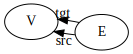

In [10]:
to_graphviz(SchGraph)

An example graph with 4 vertices and 2 edges.

In [11]:
g = @acset Catlab.Graphs.Graph begin
  V = 4
  E = 2
  src=[1,2]
  tgt = [2,3]
end

E,src,tgt
1,1,2
2,2,3


Note that the vertices are listed out in a somewhat silly way. They are given as a table with no columns, so they show up in the JSON as a bunch of empty objects. This is for consistency with our next example.

In [12]:
JSON.print(generate_json_acset(g), 2)

{
  "V": [
    {},
    {},
    {},
    {}
  ],
  "E": [
    {
      "src": 1,
      "tgt": 2
    },
    {
      "src": 2,
      "tgt": 3
    }
  ]
}


## Example 4: Vertex and Edge Labeled Graph Graph Schema

You can extend schemas by adding more tables and columns. This inheritance is flattened when you serialize to JSON, but could be encoded in a future version.

In [13]:
@present SchVELabeledGraph <: SchGraph begin
  Label::AttrType
  vlabel::Attr(V,Label)
  elabel::Attr(E,Label)
end

JSON.print(generate_json_acset_schema(SchVELabeledGraph), 2)

{
  "version": {
    "ACSetSchema": "0.0.1",
    "Catlab": "0.0.0"
  },
  "Ob": [
    {
      "name": "V"
    },
    {
      "name": "E"
    }
  ],
  "Hom": [
    {
      "name": "src",
      "codom": "V",
      "dom": "E"
    },
    {
      "name": "tgt",
      "codom": "V",
      "dom": "E"
    }
  ],
  "AttrType": [
    {
      "name": "Label"
    }
  ],
  "Attr": [
    {
      "name": "vlabel",
      "codom": "Label",
      "dom": "V"
    },
    {
      "name": "elabel",
      "codom": "Label",
      "dom": "E"
    }
  ]
}


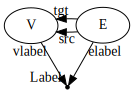

In [14]:
to_graphviz(SchVELabeledGraph)

An example labeled graph using symbols for the vertex and edge names. Note that you can use unicode symbols in Julia.

In [15]:
@acset_type VELabeledGraph(SchVELabeledGraph,
                           index=[:src,:tgt]) <: AbstractGraph

lg = @acset VELabeledGraph{Symbol} begin
  V = 4
  E = 2
  vlabel = [:a, :b, :c, :d]
  elabel = [:e₁, :e₂]
  src=[1,2]
  tgt = [2,3]
end

Main.var"##293".VELabeledGraph{Symbol} with elements V = 1:4, E = 1:2
┌───┬────────┐
│ V │ vlabel │
├───┼────────┤
│ 1 │      a │
│ 2 │      b │
│ 3 │      c │
│ 4 │      d │
└───┴────────┘
┌───┬─────┬─────┬────────┐
│ E │ src │ tgt │ elabel │
├───┼─────┼─────┼────────┤
│ 1 │   1 │   2 │     e₁ │
│ 2 │   2 │   3 │     e₂ │
└───┴─────┴─────┴────────┘

This Graph is represented by the following JSON. Now you can see that the vertices have their `vlabels`

In [16]:
JSON.print(generate_json_acset(lg), 2)

{
  "V": [
    {
      "vlabel": "a"
    },
    {
      "vlabel": "b"
    },
    {
      "vlabel": "c"
    },
    {
      "vlabel": "d"
    }
  ],
  "E": [
    {
      "src": 1,
      "tgt": 2,
      "elabel": "e₁"
    },
    {
      "src": 2,
      "tgt": 3,
      "elabel": "e₂"
    }
  ]
}
